(cone-nb)=
# Berry phase around graphene's Dirac cone

This example computes Berry phases for a circular path (in reduced
coordinates) around the Dirac point of the graphene band structure. In
order to have a well defined sign of the Berry phase, a small on-site
staggered potential is added to open a gap at the Dirac point.

After computing the Berry phase around the circular loop, it also computes
the integral of the Berry curvature over a small square patch in the
Brillouin zone containing the Dirac point, and plots individual phases
for each plaquette in the array.

In [1]:
from pythtb import TBModel, WFArray, Mesh
import numpy as np
import matplotlib.pyplot as plt

First we build the tight-binding model for graphene with a staggered onsite potential.

In [2]:
# define lattice vectors
lat = [[1.0, 0.0], [0.5, np.sqrt(3.0) / 2.0]]
# define coordinates of orbitals
orb = [[1.0 / 3.0, 1.0 / 3.0], [2.0 / 3.0, 2.0 / 3.0]]

# make two dimensional tight-binding graphene model
my_model = TBModel(2, 2, lat, orb)

# set model parameters
delta = -0.1  # small staggered onsite term
t = -1.0

# set on-site energies
my_model.set_onsite([-delta, delta])
# set hoppings (amplitude, i, j, [lattice vector to cell containing j])
my_model.set_hop(t, 0, 1, [0, 0])
my_model.set_hop(t, 1, 0, [1, 0])
my_model.set_hop(t, 1, 0, [0, 1])

print(my_model)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 2
k-space dimension           = 2
number of spin components   = 1
periodic directions         = [0, 1]
number of orbitals          = 2
number of electronic states = 2

Lattice vectors (Cartesian):
  # 0 ===> [ 1.000 ,    0   ]
  # 1 ===> [ 0.500 ,  0.866 ]
Orbital vectors (dimensionless):
  # 0 ===> [ 0.333 ,  0.333 ]
  # 1 ===> [ 0.667 ,  0.667 ]
Site energies:
  # 0 ===>  0.100 
  # 1 ===> -0.100 
Hoppings:
  < 0 | H | 1 + [ 0.0 ,  0.0 ] >  ===> -1.0000
  < 1 | H | 0 + [ 1.0 ,  0.0 ] >  ===> -1.0000
  < 1 | H | 0 + [ 0.0 ,  1.0 ] >  ===> -1.0000
Hopping distances:
  | pos(0) - pos(1 + [ 0.0 ,  0.0 ]) | =  0.577 
  | pos(1) - pos(0 + [ 1.0 ,  0.0 ]) | =  0.577 
  | pos(1) - pos(0 + [ 0.0 ,  1.0 ]) | =  0.577 


## Circular path around Dirac cone

First we will construct the circular path of k-points around the Dirac cone.

In [3]:
circ_step = 31 # number of steps in the circular path
circ_center = np.array([1/3, 2/3]) # the K point
circ_radius = 0.1 # the radius of the circular path

# construct k-point coordinate on the path
kpts = []
for i in range(circ_step):
    ang = 2*np.pi * i / (circ_step - 1)
    kpt = np.array([np.cos(ang) * circ_radius, np.sin(ang) * circ_radius])
    kpt += circ_center
    kpts.append(kpt)

### `Mesh` class
We will now utilize the `Mesh` class to store the k-point mesh along the path. We pass the `TBModel` object as the argument.

In this case, we have a one-dimensional k-point path in a two-dimensional Brillouin zone, so we use the `build_path` method to create the path. We pass the `path_k` variable, which is a list of the nodes in the path that the k-points will be interpolated between. In our example, the nodes are the points themselves, so we use `n_interp=1` which specifies the number of points between the nodes. This will just store the list of `circ_step` k-points we have already constructed. 

:::{tip}
`n_interp` is an optional parameter that specifies the number of interpolation points between each pair of nodes in the path. By default, it is set to 1. This default behavior means that the k-point path will consist only of the nodes specified in `path_k`, without any additional points in between. If you want to create a denser k-point path with more points between the nodes, you can increase the value of `n_interp`.
:::

In [4]:
mesh = Mesh(my_model)
mesh.build_path(path_k=kpts, n_interp=1)

TypeError: Mesh.build_path() got an unexpected keyword argument 'path_k'

### `WFArray` class

We now construct a `WFArray` object to hold the wavefunction data for each k-point in the mesh. The `WFArray` class is designed to work seamlessly with the `Mesh` class, allowing us to easily associate wavefunction data with the specific k-points (or parameter points) stored in the `Mesh`. 

In [5]:
w_circ = WFArray(my_model, mesh)

To populate the `WFArray` object with wavefunction data, we can use the `solve_k_mesh()` method, which computes the wavefunctions for each k-point in the mesh.

In [6]:
w_circ.solve_k_mesh()

### Berry phase
We can compute the Berry phase along the circular path using the `berry_phase` method of the `WFArray` object. This method takes a list of band indices as input and returns the Berry phase for those bands.

In [7]:
berry_phase_0 = w_circ.berry_phase([0])
berry_phase_1 = w_circ.berry_phase([1])
berry_phase_both = w_circ.berry_phase([0, 1])

print(f"Berry phase along circle with radius {circ_radius} and centered at k-point {circ_center}")
print(f"for band 0 equals    : {berry_phase_0}")
print(f"for band 1 equals    : {berry_phase_1}")
print(f"for both bands equals: {berry_phase_both}")

Berry phase along circle with radius 0.1 and centered at k-point [0.33333333 0.66666667]
for band 0 equals    : [2.56368315]
for band 1 equals    : [-2.56368315]
for both bands equals: [2.19742122e-16]


## Square patch around Dirac cone

Next, we construct a two-dimensional square patch covering the Dirac cone.

In [8]:
square_step = 31
square_center = np.array([1/3, 2/3])
square_length = 0.1

all_kpt = np.zeros((square_step, square_step, 2))
for i in range(square_step):
    for j in range(square_step):
        kpt = np.array(
            [
                square_length * (-0.5 + i / (square_step - 1)),
                square_length * (-0.5 + j / (square_step - 1)),
            ]
        )
        kpt += square_center
        all_kpt[i, j, :] = kpt

### `Mesh` class

:::{versionadded} 2.0.0
:::

Again, we add the k-points into the `Mesh` object, but this time by calling the `build_grid` method. In circumstances where we have a regular grid of k-points, this method is particularly useful as it can automatically generate the necessary k-point coordinates based on the specified grid parameters. We can also specify the grid directly by passing the `points` parameter. 

:::{warning}
The `points` array must have a shape that corresponds to `shape_k`. For example, if `shape_k` is `(4, 4)`, then `points` should have the shape `(4, 4, 2)` to represent the k-point coordinates in 2D.
:::

In [ ]:
mesh = Mesh(my_model)
mesh.build_grid(shape_k=(square_step, square_step), points=all_kpt)

### `WFArray` class
Now we do the same thing as before to solve the model on these k-points, by calling `solve_k_mesh` on the `WFArray` object.

In [16]:
w_square = WFArray(my_model, mesh)
w_square.solve_k_mesh()

### Berry flux

Next, we can compute the Berry flux on this square grid of k-points by calling `WFArray.berry_flux`. We pass as arguments the band indices and optionally can specify the plane on which the Berry flux should be computed. 

:::{note}
In our case, we have only one plane since the system is two-dimensional and we are interested in the Berry flux in the kx-ky plane.
However, if `plane` is unspecified, the Berry flux will be computed for all available planes, and will be returned with an additional set of two axes corresponding to each dimension in parameter space. Since the Berry flux is an anti-symmetric tensor, the `[0,1]` and `[1,0]` components will be related by a minus sign. So here, we specify the plane so the returned object just gets the upper left (`[0,1]`) component.
:::

In [14]:
b_flux_0 = w_square.berry_flux([0], plane=(0, 1))
b_flux_1 = w_square.berry_flux([1], plane=(0, 1))
b_flux_both = w_square.berry_flux([0, 1], plane=(0, 1))

print(f"Berry flux on square patch with length: {square_length} and centered at k-point: {square_center}")
print("for band 0 equals    : ", np.sum(b_flux_0))
print("for band 1 equals    : ", np.sum(b_flux_1))
print("for both bands equals: ", np.sum(b_flux_both))

Berry flux on square patch with length: 0.1 and centered at k-point: [0.33333333 0.66666667]
for band 0 equals    :  2.1792164801315166
for band 1 equals    :  -2.179216480131517
for both bands equals:  6.049657340588258e-16


Let's plot the Berry flux distribution in the kx-ky plane.

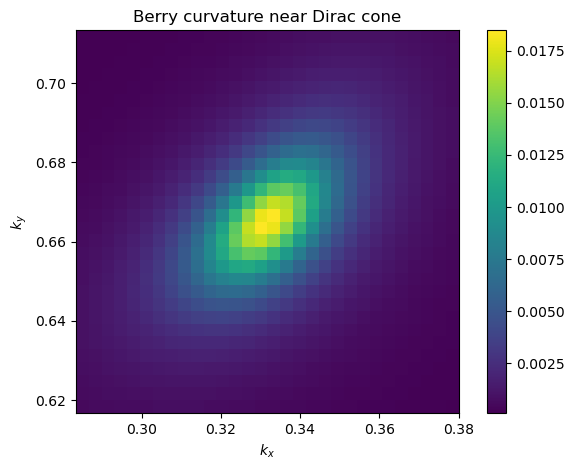

In [17]:
fig, ax = plt.subplots()
img = ax.imshow(
    b_flux_0.T.real,
    origin="lower",
    extent=(
        all_kpt[0, 0, 0],
        all_kpt[-2, 0, 0],
        all_kpt[0, 0, 1],
        all_kpt[0, -2, 1],
    ),
)
ax.set_title("Berry curvature near Dirac cone")
ax.set_xlabel(r"$k_x$")
ax.set_ylabel(r"$k_y$")
plt.colorbar(img)
fig.tight_layout()